In [3]:
import numpy as np
import ruptures as rpt
import sys,os,copy,pdb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import plot_helper as ph
import pandas as pd
import misc

In [4]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [5]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_first_trial_burst_simulation_artifact'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_first_trial_burst_simulation_artifact
/mnt/home/szheng/ceph/place_variability/data/paper


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [6]:
np.random.seed(2)

In [43]:
rate = 10
ntrial = 30
nrepeats = 2000#1000
data_null=np.random.poisson(rate,size=(nrepeats,ntrial))
data_null = pd.DataFrame(data_null)

In [44]:
import change_point_analysis as cpa
X = data_null / data_null.max(axis=1).values[:,None]
X_norm_pwc,cpts=cpa.predict_from_cpts_wrapper_allrows(X,1,cost='l2',min_size=2,model_type=rpt.Dynp)
# X_norm_pwc,cpts=cpa.predict_from_cpts_wrapper_allrows(X,0.3,cost='l2',min_size=2,model_type=rpt.Pelt)
# cpts=cpts.dropna(axis=0,how='all').dropna(axis=1)
cpts = cpts[0]

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
peri_sw_l = []
sw_mag_l = []
trial_win = 3

for uid, cpt in cpts.items():
    st,ed=cpt-trial_win,cpt+trial_win
    st = np.maximum(st,0)
    ed = np.minimum(ed,ntrial)
    sw_mag=X_norm_pwc.loc[uid,cpt] -X_norm_pwc.loc[uid,cpt-1]
    sw_mag_l.append(sw_mag)
    section_post=X.loc[uid,cpt:ed].reset_index(drop=True)
    section_pre=X.loc[uid,st:(cpt-1)]
    section_pre.index=section_pre.index - cpt
    section_pre = section_pre.sort_index()
    peri_sw_l.append(pd.concat([section_pre,section_post]))

peri_sw_l = pd.concat(peri_sw_l,axis=1).T
sw_mag_l= np.array(sw_mag_l)

In [46]:
toplot.shape

(481, 7)

In [16]:
from importlib import reload
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

thresh 0
{(-3, -2): WilcoxonResult(statistic=37014.0, pvalue=0.8798640015707215), (-2, -1): WilcoxonResult(statistic=25559.0, pvalue=1.4311084165183774e-12), (-1, 0): WilcoxonResult(statistic=9.5, pvalue=3.562468312950447e-80), (0, 1): WilcoxonResult(statistic=35702.5, pvalue=8.184535754400417e-07), (1, 2): WilcoxonResult(statistic=29804.0, pvalue=0.0002512920894558811), (2, 3): WilcoxonResult(statistic=34494.0, pvalue=0.37919164821593443)}


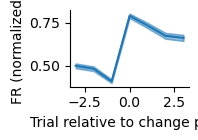

In [26]:
# fig,axs=plt.subplots(2,1,sharex=True,sharey=True,figsize=(3,3))
# for ii,thresh in enumerate([0,0.3]):
#     ax=axs[ii]
#     toplot=peri_sw_l[sw_mag_l>thresh]
# #     testres = scipy.stats.wilcoxon(toplot[0]-toplot[1])
#     print(f'thresh {thresh}')
#     print(ph.consecutive_wilcoxon_test(toplot))
#     fig,ax=ph.mean_error_plot(toplot,xs=None,ci_scale=1.96,axis=0,fig=fig,ax=ax,alpha=0.5,label=None,sem=True,linestyle='-',c='C0')
#     ax.set_title(f'FR increase > {thresh}')
    
#     ax.set_ylabel('FR (normalized)')
#     sns.despine()
# ax.set_xlabel('Trial relative to change point')
# plt.tight_layout()


# # figfn= 'peri_sw_on_sim'
# # ph.save_given_name(fig,figfn,figdir)

{(-3, -2): WilcoxonResult(statistic=148257.0, pvalue=0.059496282864568144), (-2, -1): WilcoxonResult(statistic=119570.0, pvalue=2.344849282988137e-19), (-1, 0): WilcoxonResult(statistic=0.0, pvalue=2.4033747903011223e-159), (0, 1): WilcoxonResult(statistic=125192.5, pvalue=1.3438839383164608e-19), (1, 2): WilcoxonResult(statistic=146360.0, pvalue=0.1931487811896665), (2, 3): WilcoxonResult(statistic=116750.5, pvalue=0.0008824611788016757)}


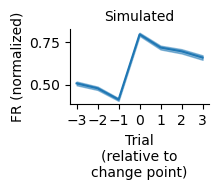

In [54]:
from matplotlib.ticker import MaxNLocator
fig,ax=plt.subplots(1,1,sharex=True,sharey=True,figsize=(2.2,2))

thresh=0

toplot=peri_sw_l[sw_mag_l>thresh]
print(ph.consecutive_wilcoxon_test(toplot))
fig,ax=ph.mean_error_plot(toplot,xs=None,ci_scale=1.96,axis=0,fig=fig,ax=ax,alpha=0.5,label=None,sem=True,linestyle='-',c='C0')
ax.set_title(f'Simulated')

ax.set_ylabel('FR (normalized)')
sns.despine()
ax.set_xlabel('Trial\n(relative to\nchange point)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()


figfn= 'peri_sw_on_sim'
ph.save_given_name(fig,figfn,figdir)

In [22]:
# import test_change_point as tcp

# signal = X.loc[uid].values
# pval_df,_,_=tcp.test_contiguity(signal,n_shuffle=200,sig_thresh=0.05,n_change_pts=1,min_size=2,signal_shuffle=None)


In [19]:
sw_mag_l

array([ 0.12222222, -0.175     ,  0.203125  , -0.08203125, -0.1875    ,
        0.17261905, -0.11869748,  0.10714286,  0.1625    ,  0.19543651,
       -0.15740741, -0.11769481,  0.17582418,  0.11157895, -0.10746606,
        0.16533759,  0.2670068 ,  0.1015528 , -0.14912281,  0.15570175,
        0.13068938, -0.1489899 , -0.14351852, -0.08412698, -0.09895833,
       -0.19      , -0.35368421, -0.10714286,  0.13958333, -0.18076923,
        0.09553571,  0.27406417, -0.13104732,  0.20781893,  0.12058824,
        0.21568627,  0.19583333,  0.16620879, -0.13595583, -0.10352941,
        0.3592437 , -0.12745098, -0.13492063,  0.19103314, -0.16987179,
        0.140625  , -0.19012346,  0.1697861 ,  0.16764706, -0.17692308,
       -0.10385338, -0.1625    ,  0.16112532,  0.23764706, -0.20888889,
        0.13647059, -0.22115385,  0.20833333, -0.24537037, -0.37254902,
        0.12799043, -0.06502827,  0.0978836 ,  0.21875   ,  0.10620915,
       -0.15      ,  0.16111111,  0.08889752, -0.13961039,  0.18

In [55]:
%%time
import test_change_point as tcp
res = tcp.test_contiguity_allrows(X,n_shuffle=200,sig_thresh=0.05,n_change_pts=1,min_size=2)
# res = tcp.test_contiguity_allrows(X[:200],n_shuffle=1000,sig_thresh=0.05,n_change_pts=1,min_size=2)


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


CPU times: user 4.05 s, sys: 1.46 s, total: 5.51 s
Wall time: 3min 37s


In [58]:
pval_all=np.array([r[0].pval for r in res])

array([-0.17916002,  0.13507625, -0.15185185, ...,  0.21990741,
        0.11992945, -0.13866667])

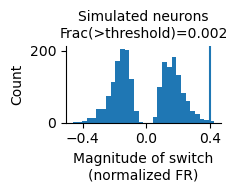

In [84]:
fig,ax=plt.subplots(figsize=(2,1))
ax.hist(sw_mag_l,bins=30)
ax.axvline(0.4)
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.set_xlabel('Magnitude of switch\n(normalized FR)')
sns.despine()
ax.set_ylabel('Count')
frac = (sw_mag_l>0.4).mean()
ax.set_title(f'Simulated neurons\nFrac(>threshold)={frac:.3f}')

figfn = 'shuffle_test_sw_for_sim_sw_mag_hist'
ph.save_given_name(fig,figfn,figdir)

In [85]:
type1err_frac=(pval_all<0.05).mean()

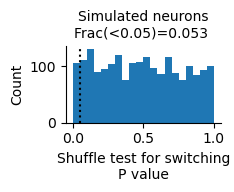

In [87]:
fig,ax=plt.subplots(figsize=(2,1))
ax.hist(pval_all,bins=20)
ax.axvline(0.05,linestyle=':',color='k')
# ax.set_title(f'Simulated neurons\nFalse positive rate: {type1err_frac} ')
ax.set_title(f'Simulated neurons\nFrac(<0.05)={type1err_frac} ')
ax.set_ylabel('Count')
ax.set_xlabel('Shuffle test for switching\nP value')
sns.despine()

figfn = 'shuffle_test_sw_for_sim_pval_hist'
ph.save_given_name(fig,figfn,figdir)

In [81]:
is_sw_on=(pval_all<0.05)&(sw_mag_l>0.4)
is_sw_on.mean()

0.001

# if just pick the largest change

In [127]:
cpts = X.diff(axis=1).idxmax(axis=1)
X_norm_pwc = X

In [128]:
peri_sw_l = []
sw_mag_l = []

for uid, cpt in cpts.items():
    st,ed=cpt-3,cpt+3
    st = np.maximum(st,0)
    ed = np.minimum(ed,ntrial)
    sw_mag=X_norm_pwc.loc[uid,cpt] -X_norm_pwc.loc[uid,cpt-1]
    sw_mag_l.append(sw_mag)
    section_post=X.loc[uid,cpt:ed].reset_index(drop=True)
    section_pre=X.loc[uid,st:(cpt-1)]
    section_pre.index=section_pre.index - cpt
    section_pre = section_pre.sort_index()
    peri_sw_l.append(pd.concat([section_pre,section_post]))

peri_sw_l = pd.concat(peri_sw_l,axis=1).T
sw_mag_l= np.array(sw_mag_l)

Text(0, 0.5, 'FR (normalized)')

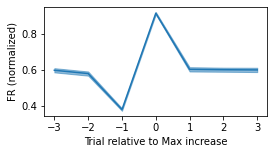

In [134]:
fig,axs=plt.subplots(1,1,figsize=(4,2))
# for ii,thresh in enumerate([0]):
ax=axs
toplot=peri_sw_l[sw_mag_l>thresh]
fig,ax=ph.mean_error_plot(toplot,xs=None,ci_scale=1.96,axis=0,fig=fig,ax=ax,alpha=0.5,label=None,sem=True,linestyle='-',c='C0')
#     ax.set_title(f'FR increase > {thresh}')
ax.set_xlabel('Trial relative to Max increase')
ax.set_ylabel('FR (normalized)')
# plt.tight_layout()


<Axes: >

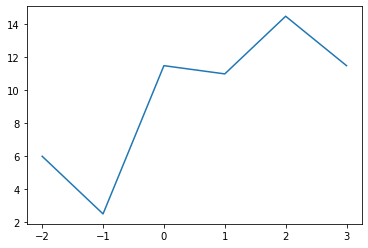

In [103]:
peri_sw_on.mean().plot()